In [ ]:
# from google.colab import runtime
# runtime.unassign()

In [ ]:
!unzip /content/deepface1333.zip -d "/content/"

Archive:  /content/deepface1333.zip
   creating: /content/deepface1333/
   creating: /content/deepface1333/data/
   creating: /content/deepface1333/data/train/
   creating: /content/deepface1333/data/train/ben_afflek/
  inflating: /content/deepface1333/data/train/ben_afflek/httpimagesfandangocomrImageRendererredesignstaticimgnoxportraitjpgpcpcpcimagesmasterrepositoryperformerimagespjpg.jpg  
  inflating: /content/deepface1333/data/train/ben_afflek/httpssmediacacheakpinimgcomxdfdfadcfeabjpg.jpg  
  inflating: /content/deepface1333/data/train/ben_afflek/httpssmediacacheakpinimgcomxeebdfdbaaajpg.jpg  
  inflating: /content/deepface1333/data/train/ben_afflek/httpsuploadwikimediaorgwikipediacommonsthumbddBenAffleckbyGageSkidmorejpgpxBenAffleckbyGageSkidmorejpg.jpg  
  inflating: /content/deepface1333/data/train/ben_afflek/httptrwebimgacstanetcxbdddmediasnmediajpg.jpg  
  inflating: /content/deepface1333/data/train/ben_afflek/httpwwwaceshowbizcomimagesphotobenaffleckjpg.jpg  
  inflating: /c

In [ ]:
!pip install deepface 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 KB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116949 sha256=5750254d1ee33bb246b68c21174d9f1bb9e2ca71d26b296a4faa8c30951ca43c
  Stored in directory: /root/.cache/pip/wheels/5b/eb/43/7295e71293b218ddfd627f935229bf54af9018add7fbb5aac6
Successfully built fire


In [ ]:
import time
from os import path
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle

from deepface.basemodels import VGGFace, OpenFace, Facenet, Facenet512, FbDeepFace, DeepID, DlibWrapper, ArcFace, Boosting
from deepface.extendedmodels import Age, Gender, Race, Emotion
from deepface.commons import functions, realtime, distance as dst
from deepface import DeepFace

import matplotlib.pyplot as plt
import tensorflow as tf

Directory  /root /.deepface created
Directory  /root /.deepface/weights created


In [ ]:
from os import listdir
from os.path import isdir
from PIL import Image
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN
 
# load images and extract faces từ đường dẫn
def load_faces(directory):
 faces = list()
 # enumerate files
 for filename in listdir(directory):
 # path
     path = directory + filename
 # get face
    #  face = extract_face(path)
 # store
     faces.append(path)
 return faces
 
# load a dataset 
def load_dataset(directory):
 X, y = list(), list()

 for subdir in listdir(directory):
 # path
    path = directory + subdir + '/'
 # skip any files that might be in the dir
    if not isdir(path):
       continue
    # load all faces in the subdirectory
    faces = load_faces(path)
    # create labels
    labels = [subdir for _ in range(len(faces))]
    # summarize progress
    print('>loaded %d examples for class: %s' % (len(faces), subdir))
    # store
    X.extend(faces)
    y.extend(labels)
 return asarray(X), asarray(y)
 
# load train dataset
trainX, trainy = load_dataset('/content/deepface1333/data/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('/content/deepface1333/data/val/')
print(testX.shape, testy.shape)
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

>loaded 9 examples for class: trump
>loaded 9 examples for class: dwayne_johnson
>loaded 9 examples for class: ben_afflek
>loaded 9 examples for class: gautam_rode
>loaded 9 examples for class: mindy_kaling
>loaded 9 examples for class: cillian_murphy
>loaded 9 examples for class: jerry_seinfeld
>loaded 9 examples for class: madonna
>loaded 9 examples for class: obama
(81,) (81,)
>loaded 4 examples for class: trump
>loaded 5 examples for class: dwayne_johnson
>loaded 4 examples for class: ben_afflek
>loaded 3 examples for class: gautam_rode
>loaded 4 examples for class: mindy_kaling
>loaded 5 examples for class: cillian_murphy
>loaded 5 examples for class: jerry_seinfeld
>loaded 3 examples for class: madonna
>loaded 4 examples for class: obama
(37,) (37,)


In [ ]:
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model
import os
 
 
# load the face dataset
data = load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

# convert each face in the train set to an embedding
newTrainX = []

train_dir = '/content/deepface1333/data/train/'
for directory in os.listdir(train_dir):
    for i in os.listdir(os.path.join(train_dir, directory)):
        embedding = DeepFace.represent(img_path = os.path.join(train_dir, directory, i), model_name = 'Facenet')
        newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)




# convert each face in the test set to an embedding
newTestX = []
val_dir = '/content/deepface1333/data/val/'
for directory in os.listdir(val_dir):
    for i in os.listdir(os.path.join(val_dir, directory)):
        embedding = DeepFace.represent(img_path = os.path.join(val_dir, directory, i), model_name = 'Facenet')
        newTestX.append(embedding)


newTestX = asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

Loaded:  (81,) (81,) (37,) (37,)
facenet_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /root/.deepface/weights/facenet_weights.h5
100%|██████████| 92.2M/92.2M [00:04<00:00, 22.3MB/s]


1/1 [==============================] - 0s 100ms/step
(81, 128)
1/1 [==============================] - 0s 103ms/step
(37, 128)


In [ ]:
# develop a classifier for the 5 Celebrity Faces Dataset
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
# load faces
data = load('/content/5-celebrity-faces-dataset.npz')
testX_faces = data['arr_2']
# load face embeddings
data = load('/content/5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)





# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)




SVC(kernel='linear', probability=True)

Predicted: trump (65.567)
Expected: trump


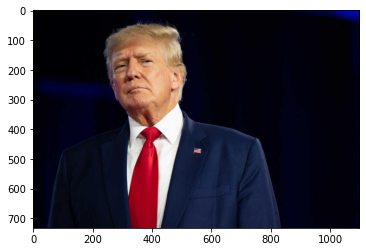

In [ ]:
import matplotlib.image as mpimg
# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
# dự đoán khuôn mặt
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
# plot image
image = mpimg.imread(random_face_pixels)
plt.imshow(image)
plt.show()

In [ ]:
import pickle
# save the model to disk
filename = 'facenet.h5'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open('/content/facenet.h5', 'rb'))
result = loaded_model.score(newTestX, testy)
print(result)

1.0


In [ ]:
import glob
# predict each face of 1 in 9 subfolder in folder "train"
path = '/content/deepface1333/data/train/trump/*'
for i in glob.glob(path):
  print(i)
  embedding = DeepFace.represent(img_path = i , model_name = 'Facenet')
  # predict face using saved model
  labels = ["Ben Affleck", "Cillian Murphy", "Dwayne Johnson", "Gautam Rode", "Jerry Seinfeld", "Madonna", "Mindy Kaling", "Obama", "Trump"]
  samples = expand_dims(embedding, axis=0)
  yhat_class = loaded_model.predict(samples)
  yhat_prob = loaded_model.predict_proba(samples)
  # get name
  class_index = yhat_class[0]
  predicted_label = labels[class_index]
  print(predicted_label)
# class_probability = yhat_prob[0,class_index] * 100
# print('Predicted: %s (%.3f)' % (predicted_label, class_probability))
# # plot image
# image = mpimg.imread(i)
# plt.imshow(image)
# plt.show()
# print(yhat_prob)

/content/deepface1333/data/train/trump/trump2.jpg
1/1 [==============================] - 0s 119ms/step
Trump
/content/deepface1333/data/train/trump/trump6.jpg
1/1 [==============================] - 0s 99ms/step
Trump
/content/deepface1333/data/train/trump/trump3.jpg
1/1 [==============================] - 0s 101ms/step
Trump
/content/deepface1333/data/train/trump/trump4.jpeg
1/1 [==============================] - 0s 121ms/step
Trump
/content/deepface1333/data/train/trump/trump1.jpeg
1/1 [==============================] - 0s 103ms/step
Trump
/content/deepface1333/data/train/trump/trump8.jpg
1/1 [==============================] - 0s 100ms/step
Trump
/content/deepface1333/data/train/trump/trump.jpg
1/1 [==============================] - 0s 107ms/step
Trump
/content/deepface1333/data/train/trump/trump10.jpg
1/1 [==============================] - 0s 121ms/step
Trump
/content/deepface1333/data/train/trump/trump5.jpg
1/1 [==============================] - 0s 112ms/step
Trump


In [ ]:
import glob
# test all folders in folder "test"
path = '/content/test/cillian_murphy/*'
for i in glob.glob(path):
  print(i)
  embedding = DeepFace.represent(img_path = i , model_name = 'Facenet')
  # predict face using saved model
  labels = ["Ben Affleck", "Cillian Murphy", "Dwayne Johnson", "Gautam Rode", "Jerry Seinfeld", "Madonna", "Mindy Kaling", "Obama", "Trump"]
  samples = expand_dims(embedding, axis=0)
  yhat_class = loaded_model.predict(samples)
  yhat_prob = loaded_model.predict_proba(samples)
  # get name
  class_index = yhat_class[0]
  predicted_label = labels[class_index]
  print(predicted_label)

/content/test/cillian_murphy/cillian-murphy2.jpg
1/1 [==============================] - 0s 107ms/step
Cillian Murphy
/content/test/cillian_murphy/cillian-murphy8.jpg
1/1 [==============================] - 0s 108ms/step
Cillian Murphy
/content/test/cillian_murphy/cillian-murphy11.jpg
1/1 [==============================] - 0s 109ms/step
Cillian Murphy
/content/test/cillian_murphy/cillian-murphy12.jpg
1/1 [==============================] - 0s 105ms/step
Cillian Murphy
/content/test/cillian_murphy/cillian-murphy1.jpg
1/1 [==============================] - 0s 114ms/step
Cillian Murphy
/content/test/cillian_murphy/cillian-murphy19.jpg
1/1 [==============================] - 0s 105ms/step
Cillian Murphy
/content/test/cillian_murphy/cillian-murphy18.jpg
1/1 [==============================] - 0s 137ms/step
Cillian Murphy
/content/test/cillian_murphy/cillian-murphy6.jpg
1/1 [==============================] - 0s 104ms/step
Cillian Murphy
/content/test/cillian_murphy/cillian-murphy7.jpg
1/1 [======